In [1]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2296046186674401620
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 1
}
incarnation: 2643519049347127767
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [2]:
from keras import backend as K
import keras.utils.np_utils

from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, ZeroPadding1D
from keras.applications.vgg16 import VGG16

from keras. preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import numpy as np
import pandas as pd

from IPython.display import SVG
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import sys
from IPython.display import display 



#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [48]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1/255, 
    horizontal_flip=True, 
    width_shift_range=.2, 
    height_shift_range=.2, 
    zoom_range =0.2, 
    fill_mode= 'nearest'
)
dir(datagen)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'mean',
 'preprocessing_function',
 'principal_components',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',
 'std',
 'vertical_flip',
 'width_shift_range',
 'zca_epsilon',
 'zca_whitening',
 'zoom_range'

In [39]:
def plot_images(x, y, **kwargs):
    n_pix = int(np.sqrt(np.prod(x.shape[1:3]))) #assumes images are square
    im_indices = np.random.choice(x.shape[0], 36, replace=False)
    fig, axes = subplots(nrows=6,ncols=6, figsize=(10,10), sharex=True, sharey=True, frameon=False)
    for i,ax in enumerate(axes.flat):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        curr_i = im_indices[i]
#         curr_label = label[argmax(y[curr_i])]
        ax.imshow(x[curr_i].reshape(n_pix,n_pix, 3), aspect="auto", **kwargs)
        ax.text(10,20,y[curr_i], fontdict={"backgroundcolor": "gray","color": "white" })
#         print(ax.set_title(title))
        ax.axis('off')
    plt.tight_layout(h_pad=0, w_pad=0)

In [55]:
%pylab inline
IMSIZE = [100, 100]
BATCH  =  40

train_gentrain_g  = datagen.flow_from_directory(class_mode='sparse',
    directory='bins/train',
    target_size=IMSIZE,
    batch_size=BATCH,
)

val_gen = datagen.flow_from_directory(class_mode='sparse',
    directory='bins/test',
    target_size=IMSIZE,
    batch_size=BATCH,
)
y,x = next(train_gentrain_g)
val_gen.filenames[0]

Populating the interactive namespace from numpy and matplotlib
Found 3995 images belonging to 89 classes.
Found 1978 images belonging to 96 classes.


'1/005897.jpg_face.jpg'

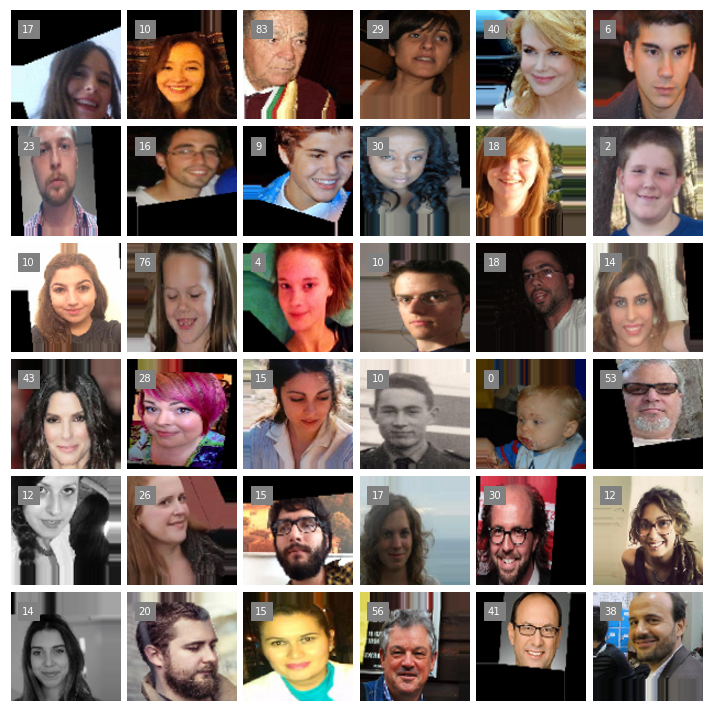

In [56]:
plot_images(y, x, interpolation="spline16")

In [57]:
print(x.shape)

(40,)


In [58]:
x.shape[1:]

()

In [59]:
x,y = next(train_gentrain_g)

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet',pooling='avg', include_top=False)


#model_vgg16_conv.summary()

# Tailor our input format (Note- Tensorflow input order!)
input = Input(shape=x.shape[1:],name = 'image_input')  # our input shape: (32,32,3)

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

#Add the fully-connected layers 
#x = Flatten(name='flatten')
x = Dense(100, activation='relu', name='fc1')(output_vgg16_conv)
x = Dense(50, activation='relu', name='fc2')(x)
x = Dense(1, activation='linear', name='predictions')(x)

#Create your own model 
my_model = Model(input=input, output=x)  # Using the Functional API
# Freeze convolutional layers
for layer in my_model.layers[:2]:
    layer.trainable=False

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 100, 100, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
fc1 (Dense)                  (None, 100)               51300     
_________________________________________________________________
fc2 (Dense)                  (None, 50)                5050      
_________________________________________________________________
predictions (Dense)          (None, 1)                 51        
Total params: 14,771,089
Trainable params: 56,401
Non-trainable params: 14,714,688
_________________________________________________________________


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


In [60]:
# must use a very small learning rate 
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

my_model.compile(optimizer='nadam', loss='mean_squared_error', metrics = ['mae'])


In [61]:
# prepare data augmentation configuration 
test_steps = val_gen.n//val_gen.batch_size
train_steps = train_gentrain_g.n//train_gentrain_g.batch_size

# same callbacks!
cb_a=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
# lets look at our results while we are at it
cb_b=keras.callbacks.ReduceLROnPlateau(factor=.5, patience=2, min_lr=1e-8)
#cb_c = keras.callbacks.ModelCheckpoint('/home/ubuntu/project_pi/model/weights.hdf5', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# fine-tune the model
history = my_model.fit_generator(
    train_gentrain_g,
    steps_per_epoch= train_steps,
    nb_epoch=100,
    validation_data=val_gen,
    validation_steps=test_steps,
    callbacks=[cb_b, cb_a])
my_model.save('tuesday1.h5')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=99, validation_data=<keras_pre..., validation_steps=49, callbacks=[<keras.ca..., epochs=100)`


Epoch 1/100
99/99 [==============================] - 46s 466ms/step - loss: 349.6225 - mean_absolute_error: 14.6340 - val_loss: 422.3180 - val_mean_absolute_error: 15.4531
Epoch 2/100
99/99 [==============================] - 46s 467ms/step - loss: 287.0114 - mean_absolute_error: 13.2885 - val_loss: 387.4414 - val_mean_absolute_error: 15.0786
Epoch 3/100
99/99 [==============================] - 46s 467ms/step - loss: 267.1203 - mean_absolute_error: 12.8101 - val_loss: 396.8412 - val_mean_absolute_error: 14.9862
Epoch 4/100
99/99 [==============================] - 46s 465ms/step - loss: 266.7007 - mean_absolute_error: 12.7324 - val_loss: 406.9794 - val_mean_absolute_error: 14.9844
Epoch 5/100
99/99 [==============================] - 46s 468ms/step - loss: 258.7579 - mean_absolute_error: 12.5098 - val_loss: 395.8357 - val_mean_absolute_error: 14.8673
Epoch 6/100
99/99 [==============================] - 46s 467ms/step - loss: 252.0755 - mean_absolute_error: 12.3503 - val_loss: 382.2132 - v

In [16]:
from keras.models import load_model

model = load_model('monday.h5')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [24]:
history.history

{'acc': [0.03126463230377003,
  0.031278010408415186,
  0.031478681989056713,
  0.031184363670416996,
  0.031117473143453422,
  0.031572328727054899],
 'loss': [195.4050959016148,
  195.14173341040791,
  194.96032837487269,
  194.91381881969647,
  194.84495115803881,
  194.7411946574301],
 'lr': [array(0.0001250000059371814, dtype=float32),
  array(0.0001250000059371814, dtype=float32),
  array(0.0001250000059371814, dtype=float32),
  array(6.25000029685907e-05, dtype=float32),
  array(6.25000029685907e-05, dtype=float32),
  array(3.125000148429535e-05, dtype=float32)],
 'val_acc': [0.030031249999999999,
  0.030171875000000001,
  0.030828125000000001,
  0.031109375000000002,
  0.030281249999999999,
  0.030390625000000001],
 'val_loss': [199.36209969711302,
  199.4736836452484,
  199.50517448997496,
  199.63549970245361,
  199.45009128761291,
  199.63021473884584]}

In [17]:
predictions  = model.predict_generator(val_gen)

In [19]:
val_gen.classes

array([ 1,  1,  1, ..., 98, 99, 99], dtype=int32)

In [18]:
predictions

array([[ 31.57940865],
       [ 36.82803726],
       [ 31.81694031],
       ..., 
       [ 46.45385742],
       [ 28.3874073 ],
       [ 33.80609894]], dtype=float32)

In [25]:
error = predictions - val_gen.classes

In [26]:
np.mean(error**2)

MemoryError: 

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['acc']) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
plt.clf()
acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']
plt.plot(epochs, history_dict['acc'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()